In [56]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
MODEL_NAME = "ARIMA"
NUM_FEATURES = 0 
TARGET_NAME = "Close"

RANGE = 51
TEST_SIZE = .19  #Porcentaje destinado al subset de pruebas
VAL_SIZE = .0

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [59]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

DF_EURUSD_ASK_1H_PROC.csv


In [60]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[0], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2018-01-01 22:00:00,1.20143,1.20173,1.20062,1.20158,1623.5100,Monday,0,0.000000,0.000000,0.00000,0.0,0.0,0.0
1,2018-01-01 23:00:00,1.20158,1.20161,1.20044,1.20110,6297.2402,Monday,0,-0.000399,-0.000399,0.00000,0.0,0.0,0.0
2,2018-01-02 00:00:00,1.20109,1.20178,1.20096,1.20162,3564.4600,Tuesday,1,0.000433,0.000832,0.00000,0.0,0.0,0.0
3,2018-01-02 01:00:00,1.20162,1.20232,1.20141,1.20159,6219.6899,Tuesday,1,-0.000025,-0.000458,0.00000,0.0,0.0,0.0
4,2018-01-02 02:00:00,1.20157,1.20165,1.20081,1.20096,5386.5098,Tuesday,1,-0.000524,-0.000499,1.20137,0.0,0.0,0.0


In [61]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (15023, 14)
               Open          High           Low         Close         Volume  \
count  15023.000000  15023.000000  15023.000000  15023.000000   15023.000000   
mean       1.141308      1.141974      1.140634      1.141303   10819.459016   
std        0.043208      0.043281      0.043139      0.043206    8543.286582   
min        1.065520      1.066840      1.063640      1.065500       1.050000   
25%        1.109760      1.110295      1.109205      1.109760    5099.780000   
50%        1.131230      1.131880      1.130610      1.131210    9308.469700   
75%        1.163455      1.164190      1.162600      1.163420   14606.439950   
max        1.254930      1.255560      1.254370      1.254930  278504.156300   

            weekday  Pct_Range_Close  Pct_Range_Close_diff    MA_Close_5  \
count  15023.000000     15023.000000          1.502300e+04  15023.000000   
mean       2.050057        -0.000005         -1.078057e-08      1.140995   
std        1.506042         0.0

In [62]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(14824, 12)
      Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0  1.20538  1.20574  1.20402  1.20443   5914.2402        4        -0.000788   
1  1.20443  1.20524  1.20426  1.20485   6369.0498        4         0.000349   
2  1.20484  1.20756  1.20458  1.20627  14090.5400        4         0.001179   
3  1.20630  1.21208  1.20525  1.21114  18746.5391        4         0.004037   
4  1.21115  1.21370  1.21111  1.21255  18016.5898        4         0.001164   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.000962    1.204850     1.201357     1.198699      1.200896  
1              0.001137    1.204908     1.201740     1.198924      1.200912  
2              0.000830    1.205220     1.202222     1.199193      1.200938  
3              0.002859    1.206414     1.202907     1.199557      1.200986  
4             -0.002873    1.207848     1.203656     1.199938      1.201041  


In [63]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  14824
Start:  0


In [64]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(14824, 12)


In [65]:
total = DF_Full.shape[0]
print('Total: ', total)

Total:  14824


### Generacion del Vector TARGET (Close)

In [66]:
#generate the VECTOR Y
Target_VectorY = DF_Full[TARGET_NAME].iloc[1:] #Se genera un Vector a partir de la posicion 1 
Target_VectorY.columns = [TARGET_NAME+'_y']
print(Target_VectorY.head())
print(Target_VectorY.shape)

#Agregar valor al final del vector para tener mismo tamaño
Target_VectorY = Target_VectorY.append(Target_VectorY.tail(1), ignore_index=True)
print(Target_VectorY.tail())
print(Target_VectorY.shape)


1    1.20485
2    1.20627
3    1.21114
4    1.21255
5    1.21190
Name: Close, dtype: float64
(14823,)
14819    1.11071
14820    1.11141
14821    1.11123
14822    1.11158
14823    1.11158
Name: Close, dtype: float64
(14824,)


In [67]:
print(DF_Full[TARGET_NAME].head(5))
print(Target_VectorY.head(5))

0    1.20443
1    1.20485
2    1.20627
3    1.21114
4    1.21255
Name: Close, dtype: float64
0    1.20485
1    1.20627
2    1.21114
3    1.21255
4    1.21190
Name: Close, dtype: float64


In [68]:
s1 = TEST_SIZE + VAL_SIZE
print('Porcentaje Total del subset de Puebas y Validacion en PCT: ',s1,'%')
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Porcentaje Total del subset de Puebas y Validacion en PCT:  0.19 %
count of Val and Test: 2816
end of train:  12008
count val:  0
count test:  2816
end_val 12008


In [69]:
#Separacion para Subsets de Training, Validation and Testing de la matriz de Features

data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("Training Dataset Shape: ", data_training.shape)
print("Validation Dataset Shape: ", data_val.shape)
print("Testing Dataset Shape: ", data_test.shape)



Training Dataset Shape:  (12008, 12)
Validation Dataset Shape:  (0, 12)
Testing Dataset Shape:  (2816, 12)


In [70]:
data_training_y = Target_VectorY.iloc[:end_train]
data_val_y = Target_VectorY.iloc[end_train: end_val]
data_test_y = Target_VectorY.iloc[end_val:]

print("Training Target Shape: ", data_training_y.shape)
print("Validation Target Shape: ", data_val_y.shape)
print("Testing Target Shape: ", data_test_y.shape)

Training Target Shape:  (12008,)
Validation Target Shape:  (0,)
Testing Target Shape:  (2816,)


In [71]:
# DATA SET SCALER TRAINING
#NORMALIZACION de 0 a 1
scaler = MinMaxScaler(feature_range=(-1, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[ 0.40616012  0.4017053   0.39497717 ...  0.38781022  0.36994369
   0.43309826]
 [ 0.39477469  0.39570073  0.39786109 ...  0.39256677  0.37280435
   0.43331847]
 [ 0.3996884   0.42356191  0.40170632 ...  0.39854473  0.37622798
   0.43366664]
 ...
 [-0.68995686 -0.69833073 -0.69334295 ... -0.69783994 -0.69827532
  -0.78493916]
 [-0.69403164 -0.70169329 -0.69346311 ... -0.69719944 -0.69946493
  -0.78452365]
 [-0.69223394 -0.69929146 -0.69045902 ... -0.69652419 -0.70058831
  -0.78411016]]


(12008, 12)


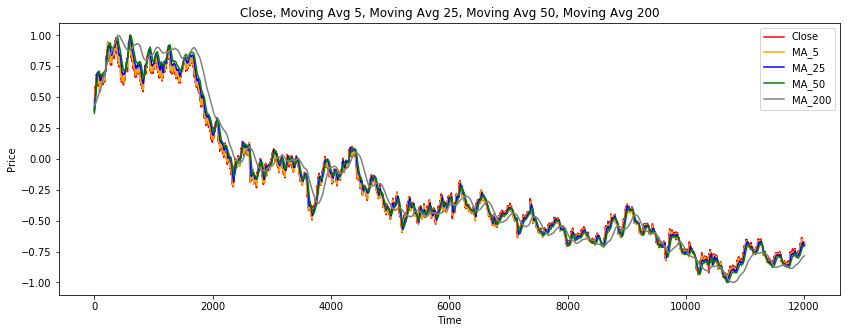

In [72]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 12008
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,8], color = 'orange', label = 'MA_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,9], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,10], color = 'green', label = 'MA_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,11], color = 'gray', label = 'MA_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

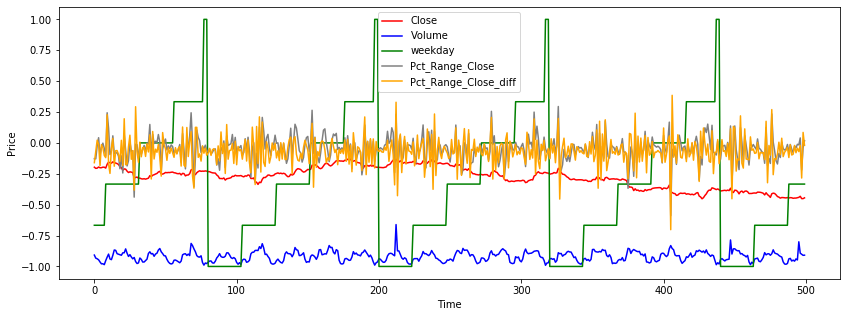

In [73]:
INICIO = 4500
FIN = 5000
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,4], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,5], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,6], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

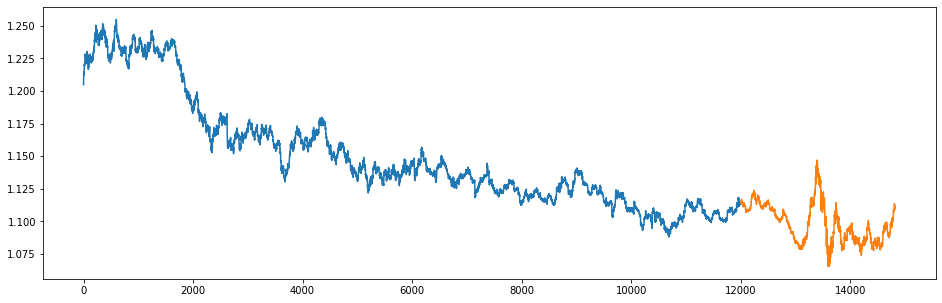

In [74]:
#PLOT de Vector TARGET (Trainig and Test)
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)
pyplot.plot(data_test_y)

In [75]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(11957, 51, 12)
(11957,)


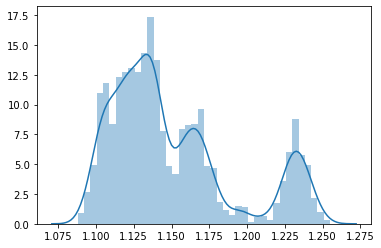

In [76]:
sns.distplot(y_train_np);


In [77]:
#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 12)
(0, 12)
<bound method NDFrame.head of        Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0   1.11833  1.11935  1.11771  1.11835   8116.7998        3        -0.000045   
1   1.11836  1.11836  1.11684  1.11699   7641.5601        4        -0.001216   
2   1.11699  1.11820  1.11682  1.11770   6966.9199        4         0.000636   
3   1.11769  1.11814  1.11725  1.11739   4586.2798        4        -0.000277   
4   1.11741  1.11781  1.11703  1.11779   4806.7202        4         0.000358   
5   1.11777  1.11779  1.11709  1.11712   3297.9199        4        -0.000599   
6   1.11712  1.11761  1.11708  1.11747   3958.2900        4         0.000313   
7   1.11746  1.11748  1.11631  1.11671   5909.3799        4        -0.000680   
8   1.11670  1.11681  1.11631  1.11657  13220.6504        4        -0.000125   
9   1.11657  1.11810  1.11650  1.11774  15447.5703        4         0.001048   
10  1.11775  1.11819  1.11689  1.11804  13416.3496        4         0.000

In [78]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.11699
1    1.11770
2    1.11739
3    1.11779
4    1.11712
5    1.11747
6    1.11671
7    1.11657
8    1.11774
9    1.11804
Name: Close, dtype: float64


In [79]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:5])

[[-0.63710451 -0.63576318 -0.64215333 -0.63686481 -0.9357929   0.
  -0.04633417 -0.57789331 -0.68390541 -0.70284971 -0.74011027 -0.80667091]
 [-0.63674497 -0.64765222 -0.65260755 -0.65316395 -0.93955466  0.33333333
  -0.19558739 -0.19200044 -0.67020943 -0.70101263 -0.7381692  -0.80603923]
 [-0.65316395 -0.64957368 -0.65284787 -0.64465484 -0.94489479  0.33333333
   0.04035357  0.13135679 -0.65941206 -0.69907625 -0.73601925 -0.80535367]
 [-0.64477469 -0.65029422 -0.64768085 -0.64837009 -0.96373878  0.33333333
  -0.07597769 -0.16436359 -0.64912196 -0.69739308 -0.73393043 -0.80471256]
 [-0.64813039 -0.65425724 -0.65032444 -0.64357622 -0.96199388  0.33333333
   0.00497483  0.00124934 -0.65059543 -0.69571985 -0.73183142 -0.80404384]]


In [80]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [81]:
#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape

(51, 12)
(2816, 12)


(2867, 12)

In [82]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(2816,)


(2867,)

In [83]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:5])

[[-0.63710451 -0.63576318 -0.64215333 -0.63686481 -0.9357929   0.
  -0.04633417 -0.57789331 -0.68390541 -0.70284971 -0.74011027 -0.80667091]
 [-0.63674497 -0.64765222 -0.65260755 -0.65316395 -0.93955466  0.33333333
  -0.19558739 -0.19200044 -0.67020943 -0.70101263 -0.7381692  -0.80603923]
 [-0.65316395 -0.64957368 -0.65284787 -0.64465484 -0.94489479  0.33333333
   0.04035357  0.13135679 -0.65941206 -0.69907625 -0.73601925 -0.80535367]
 [-0.64477469 -0.65029422 -0.64768085 -0.64837009 -0.96373878  0.33333333
  -0.07597769 -0.16436359 -0.64912196 -0.69739308 -0.73393043 -0.80471256]
 [-0.64813039 -0.65425724 -0.65032444 -0.64357622 -0.96199388  0.33333333
   0.00497483  0.00124934 -0.65059543 -0.69571985 -0.73183142 -0.80404384]]


In [84]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(2816, 51, 12)
(2816,)


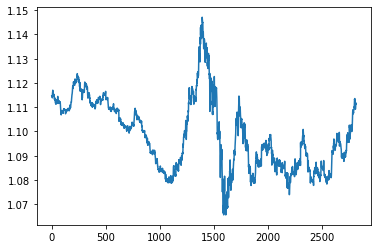

In [85]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

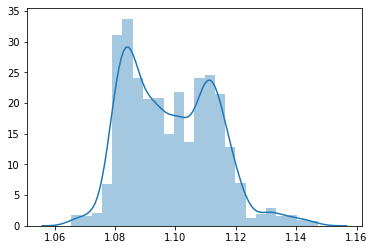

In [86]:
sns.distplot(y_test_np);


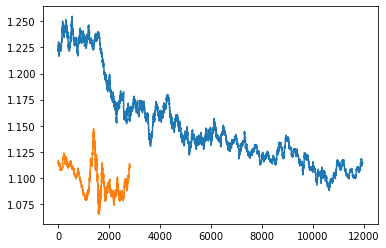

In [87]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [88]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
12


In [89]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/ARIMA/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/ARIMA/


In [90]:
# Section to implement the ARIMA model from the library statsmodels.tsa.arima_model
# fit model
#model = ARIMA(series, order=(5,1,0))


train, test = y_train_np, y_test_np
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 0.000


In [91]:
model_fit.save(source_data +'ARIMA_12F_Close_01.pkl')

In [92]:
summary = model_fit.summary()
print(summary)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                14771
Model:                 ARIMA(5, 1, 0)   Log Likelihood               80898.762
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 28 Jun 2020   AIC                        -161783.524
Time:                        20:06:51   BIC                        -161730.321
Sample:                             1   HQIC                       -161765.859
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.562e-06   7.93e-06     -0.953      0.340   -2.31e-05    7.98e-06
ar.L1.D.y     -0.0183      0.008     -2.224      0.026      -0.034      -0.002
ar.L2.D.y     -0.0155      0.008     -1.881      0.0

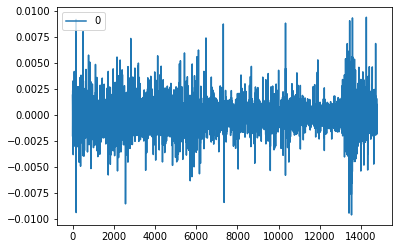

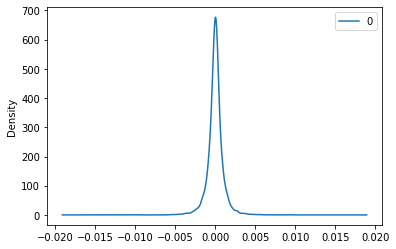

                  0
count  1.477100e+04
mean  -7.218295e-09
std    1.012059e-03
min   -9.625070e-03
25%   -4.080862e-04
50%    7.290120e-06
75%    4.069875e-04
max    9.406070e-03


In [94]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

(2816,)


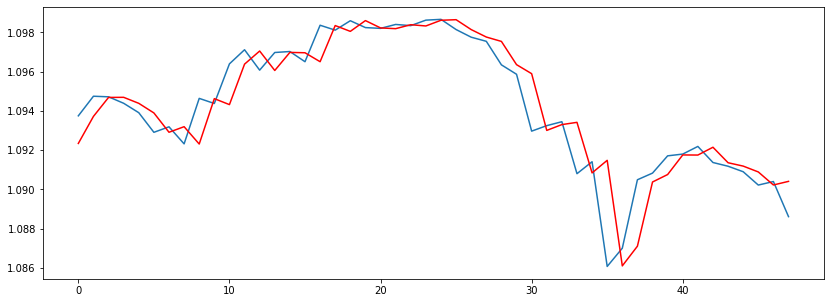

In [102]:
# plot
print(test.shape)
INICIO = 2000
FIN = 2048
plt.figure(figsize=(14,5))
pyplot.plot(test[INICIO:FIN])
pyplot.plot(predictions[INICIO:FIN], color='red')
pyplot.show()

In [103]:
print('Train MAE:', mean_absolute_error(test, predictions))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(test, predictions)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(test, predictions))#Mean Squared Error

Train MAE: 0.000781134987492233
Train RMSE: 0.001255481766473451
Train MSE: 1.576234465947297e-06


## ARIAMA de pmdarima Library:

In [1]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [43]:
values = data_training['Close']
print(values)

0        1.20443
1        1.20485
2        1.20627
3        1.21114
4        1.21255
          ...   
12003    1.11446
12004    1.11392
12005    1.11357
12006    1.11373
12007    1.11394
Name: Close, Length: 12008, dtype: float64


In [45]:
model = pm.auto_arima(values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-133072.297, BIC=-133042.724, Time=6.922 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-133072.169, BIC=-133057.383, Time=1.591 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-133072.961, BIC=-133050.781, Time=1.340 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-133073.053, BIC=-133050.873, Time=3.005 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-133073.409, BIC=-133066.016, Time=0.509 seconds
Total fit time: 13.435 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12008
Model:               SARIMAX(0, 1, 0)   Log Likelihood               66537.705
Date:                Sun, 28 Jun 2020   AIC                        -133073.409
Time:                        14:54:06   BIC                        -133066.016
Sample:                             0   

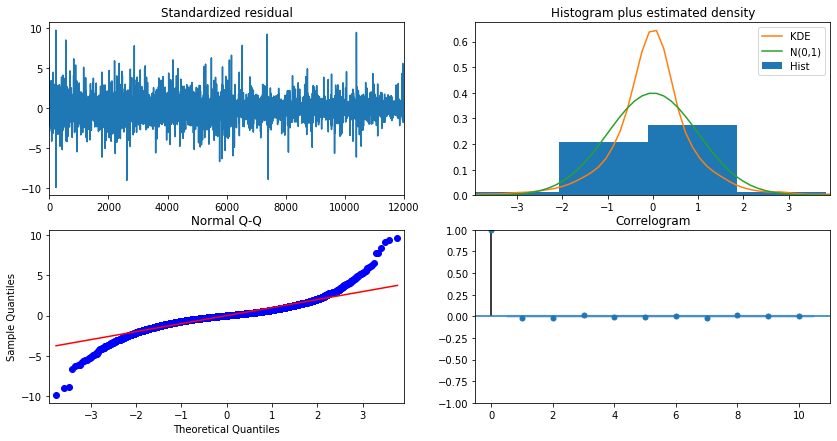

In [48]:
model.plot_diagnostics(figsize=(14,7))
plt.show()

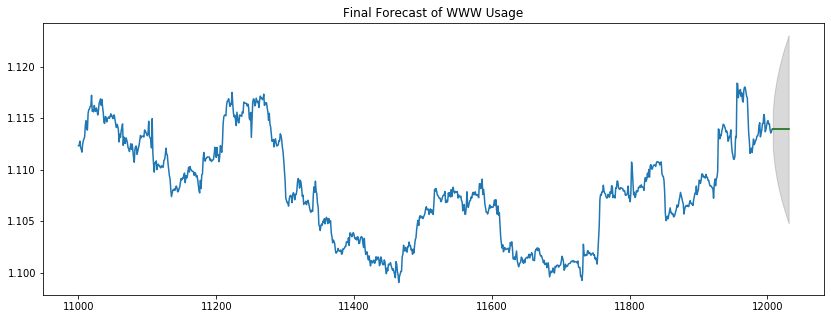

In [52]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(values), len(values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(14,5))
plt.plot(values[11000:])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

## REFERENCIAS

### A Guide to Time Series Forecasting with ARIMA in Python 3
### https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

### How to do Auto Arima Forecast in Python
### https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/